# **Лабораторная работа 4**

ФИО: Дуров Никита Олегович

Группа: БИВТ-20-6

Вариант: 5

Датасет: Matthijs/snacks 

#  **О датасете**

Датасет состоит из 20 видов закусок.

**Структура датасета:**

train    4838 

val      955 (не используются)

test     952 

**Количество картинок в каждой категории:**

apple         350

banana        350

cake          349

candy         349

carrot        349

cookie        349

doughnut      350

grape         350

hot dog       350

ice cream     350

juice         350

muffin        348

orange        349

pineapple     340

popcorn       260

pretzel       204

salad         350

strawberry    348

waffle        350

watermelon    350

# **Локально установил библиотеку dataset**


In [1]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 19.1 MB/s eta 0:00:00


# **Импорт библиотек**


In [17]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np

# **Подключение GPU**


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используется {device}")

Используется cuda


# Шаг 1. Скачивание датасета, препроцессинг данных

In [18]:
dataset = load_dataset('Matthijs/snacks')
data_transform = torchvision.transforms.Compose([torchvision.transforms.Resize((256, 256)),
                                                torchvision.transforms.ToTensor(),
                                                torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                                                                 std=[0.5, 0.5, 0.5])])

  0%|          | 0/3 [00:00<?, ?it/s]

# Шаг 2. Оформляем исходный датасет в виде класса из PyTorch, создаем лоадеры

In [19]:
class CustomDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.images = [data['image'] for data in dataset]
        self.labels = [data['label'] for data in dataset]
        self.transform = data_transform
        self.classes = dataset.features['label'].names

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

train_dataset = CustomDataset(dataset['train'], transform=data_transform)
test_dataset = CustomDataset(dataset['test'], transform=data_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Шаг 3. Визуализация картинок из датасета

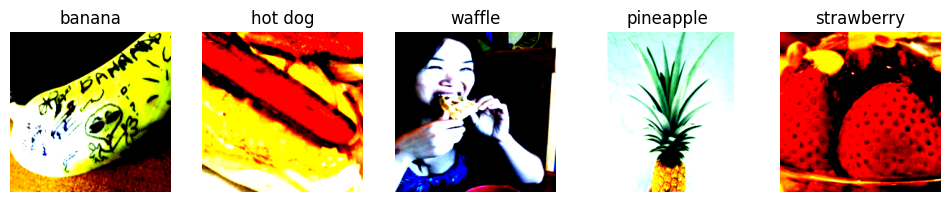

In [ ]:
import matplotlib.pyplot as plt

def show_images(images, labels, classes):
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(12, 12))

    for i in range(num_images):
        image = images[i]
        label = labels[i]
        ax = axes[i]
        ax.imshow(image.permute(1, 2, 0))
        ax.set_title(classes[label])
        ax.axis('off')

    plt.show()

num_samples = 5
random_indices = torch.randint(len(train_dataset), size=(num_samples,))
random_images = [train_dataset[i][0] for i in random_indices]
random_labels = [train_dataset[i][1] for i in random_indices]

show_images(random_images, random_labels, train_dataset.classes)



# Шаг 4. Создание и обучение собственной нейросети

In [20]:
class CustomNet(nn.Module):
    def __init__(self):
        super(CustomNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear_layer_1 = nn.Linear(4 * 256 * 256, 512)
        self.linear_layer_2 = nn.Linear(512, 1024)
        self.linear_layer_3 = nn.Linear(1024, 128)
        self.linear_layer_4 = nn.Linear(128, 20)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(-1, 4 * 256 * 256)
        x = self.linear_layer_1(x)
        x = self.relu(x)
        x = self.linear_layer_2(x)
        x = self.relu(x)
        x = self.linear_layer_3(x)
        x = self.relu(x)
        x = self.linear_layer_4(x)
        return x


net = CustomNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Поколение обучения [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")
print('Обучение завершено')


Поколение обучения [1/10], Loss: 2.9878508134892114
Поколение обучения [2/10], Loss: 2.953337594082481
Поколение обучения [3/10], Loss: 2.9031539433880855
Поколение обучения [4/10], Loss: 2.8386090648801705
Поколение обучения [5/10], Loss: 2.7619198592085588
Поколение обучения [6/10], Loss: 2.6923759767883704
Поколение обучения [7/10], Loss: 2.626681525456278
Поколение обучения [8/10], Loss: 2.5794436868868376
Поколение обучения [9/10], Loss: 2.50231229004107
Поколение обучения [10/10], Loss: 2.4366370972834135
Обучение завершено


# Шаг 5. Загрузка предобученой модели Resnet18 и ее дообучение

In [26]:
resnet18 = torchvision.models.resnet18(pretrained=True)
for param in resnet18.parameters():
    param.requires_grad = False

num_features = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_features, 20)

resnet16 = resnet18.to(device)
optimizer = optim.SGD(resnet16.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss().to(device)

num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = resnet18(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Поколение обучения [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")
print('Обучение модели с ResNet-18 завершено')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Поколение обучения [1/10], Loss: 2.6753695732668827
Поколение обучения [2/10], Loss: 1.8962293141766597
Поколение обучения [3/10], Loss: 1.4963965321841992
Поколение обучения [4/10], Loss: 1.2766579209189666
Поколение обучения [5/10], Loss: 1.1461513999261355
Поколение обучения [6/10], Loss: 1.0411201252749092
Поколение обучения [7/10], Loss: 0.9719512070480146
Поколение обучения [8/10], Loss: 0.9209566014377695
Поколение обучения [9/10], Loss: 0.877490969080674
Поколение обучения [10/10], Loss: 0.8337917727859396
Обучение модели с ResNet-18 завершено


# Вывод финальной точности

In [27]:
def calculate_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data[0].to(device), data[1].to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

accuracy = calculate_accuracy(net, test_loader)
print(f"Точность нейросети: {accuracy:.2%}")

accuracy = calculate_accuracy(resnet18, test_loader)
print(f"Точность модели с resnet18: {accuracy:.2%}")


Точность нейросети: 16.18%
Точность модели с resnet18: 76.47%
